In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Display & style settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

suppliers = pd.read_csv('suppliers.csv')
warehouses = pd.read_csv('warehouses.csv')
shipments = pd.read_csv('shipments.csv')
inspections = pd.read_csv('inspections.csv')
#Below I am getting a basic summary of each file
# Quick preview
print("\nSuppliers data\n")
print(suppliers.head())

print("\nWarehouses data\n")
print(warehouses.head())

print("\nShipments data\n")
print(shipments.head())

print("\nInspections data\n")
print(inspections.head())




Suppliers data

   supplier_id             name  country  reliability_score  lead_time_days
0            1   Hampton-Romero   Mexico              0.965              14
1            2     Reynolds Inc    India              0.947              13
2            3  Andersen-Steele  Germany              0.830              11
3            4     Smith-Hanson    India              0.728               6
4            5    White-Bennett    India              0.808               7

Warehouses data

   warehouse_id     location           manager  capacity_kg
0             1     New York    Jillian Wilson        14561
1             2  Los Angeles     Edward Pierce        13932
2             3      Chicago      Pamela White        13308
3             4      Houston  Christopher Ruiz        10949
4             5      Atlanta     Amanda Durham         7838

Shipments data

   shipment_id  supplier_id  warehouse_id        date           product  \
0            1            9             5  2024-09-19  Wh

In [42]:
shipments_by_product = shipments.groupby('product').agg(
    total_quantity_kg = ('quantity_kg', 'sum'),
    average_unit_cost = ('unit_cost', 'mean'),
    shipment_count = ('shipment_id', 'count')
).reset_index()

print(shipments_by_product)


            product  total_quantity_kg  average_unit_cost  shipment_count
0           Doodads           10371.44          12.802897             214
1           Gadgets           26462.88          44.988621             174
2      Thingamajigs           16389.90          19.094187             203
3  Whatchamacallits           25883.64          31.767594             212
4           Widgets           19225.69          25.431675             197


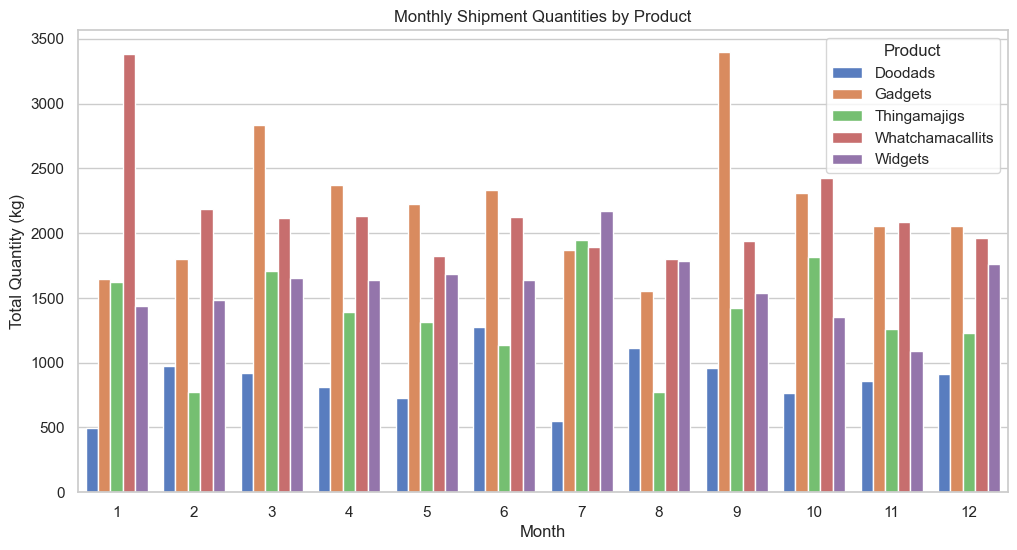

In [31]:
shipments['date'] = pd.to_datetime(shipments['date'])#the date was a string so I had to change it to a time

shipments['month'] = shipments['date'].dt.month
monthly_data = shipments.groupby(['month', 'product'])['quantity_kg'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=monthly_data, x='month', y='quantity_kg', hue='product')

plt.title('Monthly Shipment Quantities by Product')
plt.xlabel('Month')
plt.ylabel('Total Quantity (kg)')
plt.legend(title='Product')
plt.show()


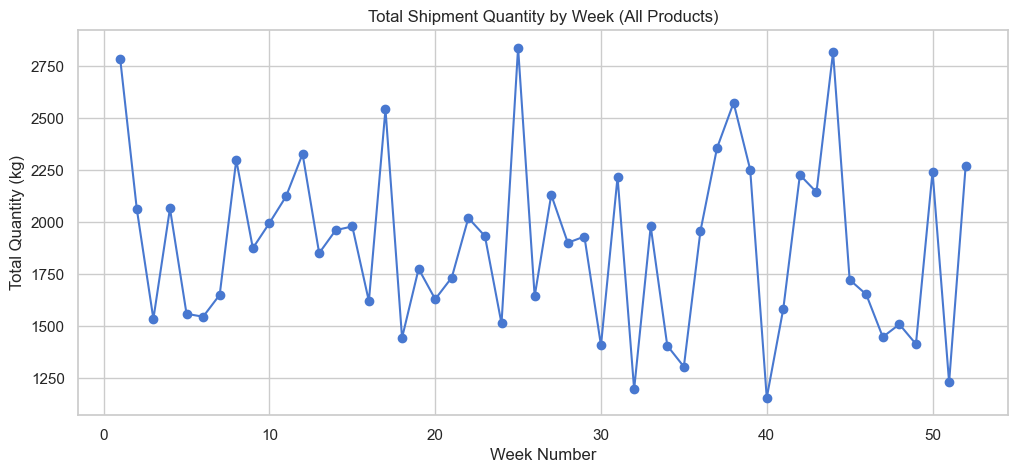

<Figure size 1200x500 with 0 Axes>

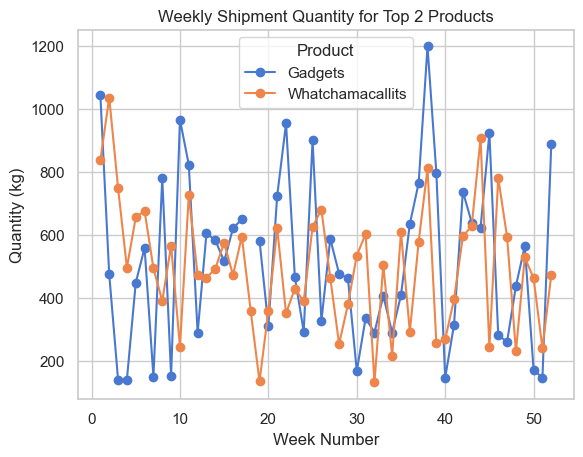

In [25]:


# Convert 'date' column to datetime
shipments['date'] = pd.to_datetime(shipments['date'])

# Add a 'week' column (ISO week number)
shipments['week'] = shipments['date'].dt.isocalendar().week

# Aggregate total quantity per week (all products combined)
weekly_totals = shipments.groupby('week')['quantity_kg'].sum()

plt.figure(figsize=(12,5))
plt.plot(weekly_totals.index, weekly_totals.values, marker='o')
plt.title('Total Shipment Quantity by Week (All Products)')
plt.xlabel('Week Number')
plt.ylabel('Total Quantity (kg)')
plt.grid(True)
plt.show()

# Find top 2 products by total quantity
top_products = shipments.groupby('product')['quantity_kg'].sum().sort_values(ascending=False).head(2).index.tolist()

# Aggregate weekly quantities for top 2 products
weekly_top_products = shipments[shipments['product'].isin(top_products)].groupby(['week','product'])['quantity_kg'].sum().unstack()

plt.figure(figsize=(12,5))
weekly_top_products.plot(marker='o')
plt.title('Weekly Shipment Quantity for Top 2 Products')
plt.xlabel('Week Number')
plt.ylabel('Quantity (kg)')
plt.grid(True)
plt.legend(title='Product')
plt.show()



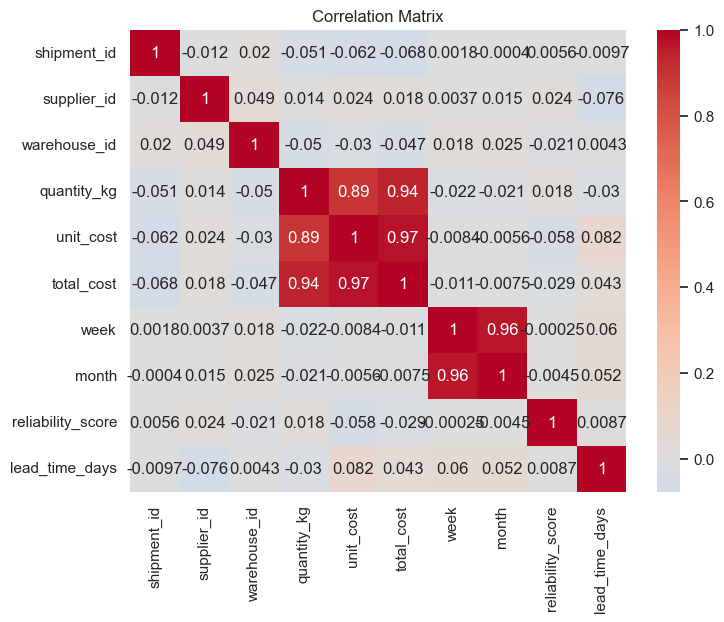

In [32]:
#Above I found no correlations or trends, so I´ll apply a heatmap to find them to use further on

# Merge shipments with supplier data for combined analysis
merged = shipments.merge(suppliers, on='supplier_id')

# Select numeric columns to correlate
numeric_cols = merged.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [27]:
#I also found nothing significant here, as I thought I would, so I´ll check every single file
#I won´t bother with a heatmap here

# Merge all relevant dataframes into one
merged_all = shipments \
    .merge(suppliers, on='supplier_id', how='left') \
    .merge(warehouses, on='warehouse_id', how='left') \
    .merge(inspections[['shipment_id', 'defect_rate']], on='shipment_id', how='left')

# Now select only numeric columns
numeric_cols = merged_all.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Now find all strong correlations
strong_corrs = corr_matrix.stack().reset_index()
strong_corrs.columns = ['feature_1', 'feature_2', 'correlation']

# Filter to show only meaningful correlations (excluding self-correlation and duplicates, more than 0.5)
strong_corrs = strong_corrs[
    (strong_corrs['feature_1'] != strong_corrs['feature_2']) & 
    (strong_corrs['correlation'].abs() > 0.5)
]

# Sort by strength
strong_corrs = strong_corrs.sort_values(by='correlation', key=abs, ascending=False)

print(strong_corrs)


             feature_1          feature_2  correlation
59          total_cost          unit_cost     0.972243
49           unit_cost         total_cost     0.972243
101        capacity_kg       warehouse_id    -0.944949
31        warehouse_id        capacity_kg    -0.944949
58          total_cost        quantity_kg     0.937334
38         quantity_kg         total_cost     0.937334
37         quantity_kg          unit_cost     0.892674
47           unit_cost        quantity_kg     0.892674
87   reliability_score        defect_rate    -0.849257
117        defect_rate  reliability_score    -0.849257


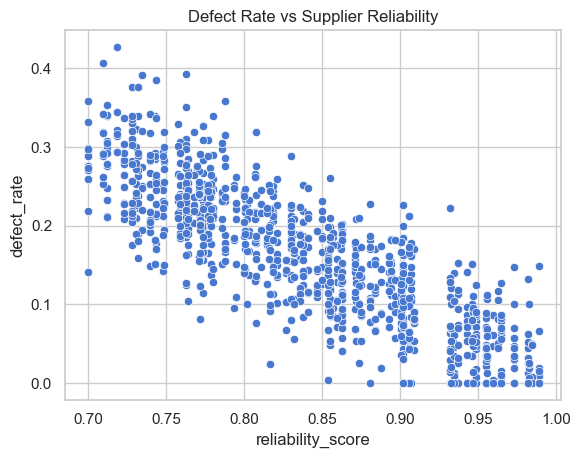

In [28]:
#Here we i am displaying the negative correlation between defect rate and supplier realibity found above
sns.scatterplot(data=merged_all, x='reliability_score', y='defect_rate')
plt.title('Defect Rate vs Supplier Reliability')
plt.show()


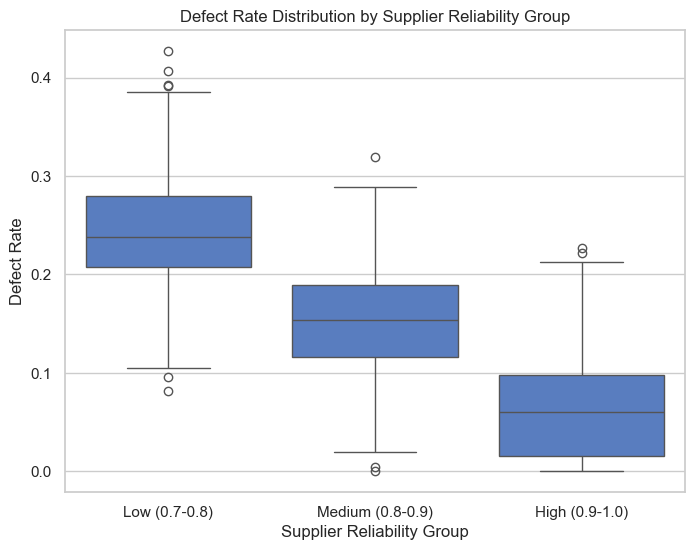

In [33]:
# Bin reliability into categories
merged_all['reliability_group'] = pd.cut(
    merged_all['reliability_score'],
    bins=[0.7, 0.8, 0.9, 1.0],
    labels=['Low (0.7-0.8)', 'Medium (0.8-0.9)', 'High (0.9-1.0)']
)

# Now plot
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_all, x='reliability_group', y='defect_rate')
plt.title('Defect Rate Distribution by Supplier Reliability Group')
plt.ylabel('Defect Rate')
plt.xlabel('Supplier Reliability Group')
plt.show()
#When we run the code we see, lets take the high reliability one, the min defect rate is 0, 
#the max is defect in the reliabilty is about 0.22, and 50% of the values are cluster 
#between UQR and LQR between 0.02 ans 0.1, showing strong consistancy

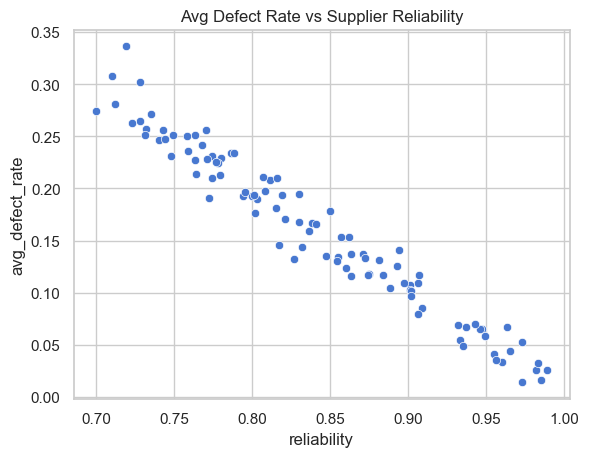

In [29]:
#This one shows the mean correlation, the average defect rate is found becasue
#all the files are merged, so linked by id number, the suppler_id in found in inspections numerios times
#averaging the defect over the number of times it has been inspected
#The reliability_score is only found in the suppliers file
by_supplier = merged_all.groupby('supplier_id').agg(
    avg_defect_rate=('defect_rate', 'mean'),
    reliability=('reliability_score', 'first')#the word first here just picks one realibity score as there is only one
)

sns.scatterplot(data=by_supplier, x='reliability', y='avg_defect_rate')
plt.title('Avg Defect Rate vs Supplier Reliability')
plt.show()
#I would like to add in terms of conclusion that no one supplier was identified as better or worse than any other, 
#but it appears quite strongly that if you remove defects you increase reliabilty

In [41]:
# Sort to see best to worst, here we have taken the varibles 
# that have the largest impact on the company and i dentified the 10 best suppliers
# and 10 lowest performing suppliers
supplier_summary = supplier_summary.sort_values(
    by=['avg_defect_rate', 'avg_reliability'], 
    ascending=[True, False]
)
print("Best performers")
print(supplier_summary.head(10))
print()
#I´ve inversed it here to show the weakest on top, you´ll see the ascending order has changed?

supplier_summary = supplier_summary.sort_values(
    by=['avg_defect_rate', 'avg_reliability'], 
    ascending=[False, True])
print("Weakest performers")
print(supplier_summary.head(10))

Best performers
    supplier_id  avg_defect_rate  avg_reliability  shipment_count
29           30         0.013875            0.973               8
82           83         0.015714            0.985               7
11           12         0.025786            0.982              14
65           66         0.025800            0.989              10
67           68         0.032429            0.983               7
21           22         0.033167            0.960               6
39           40         0.035583            0.956              12
32           33         0.041429            0.955              14
0             1         0.044389            0.965              18
93           94         0.048462            0.935              13

Weakest performers
    supplier_id  avg_defect_rate  avg_reliability  shipment_count
59           60         0.336333            0.719               6
69           70         0.308222            0.710               9
95           96         0.301700        

Coefficients: [-9.55564697e-01 -7.94698095e-05]
Intercept: 0.97091334194589


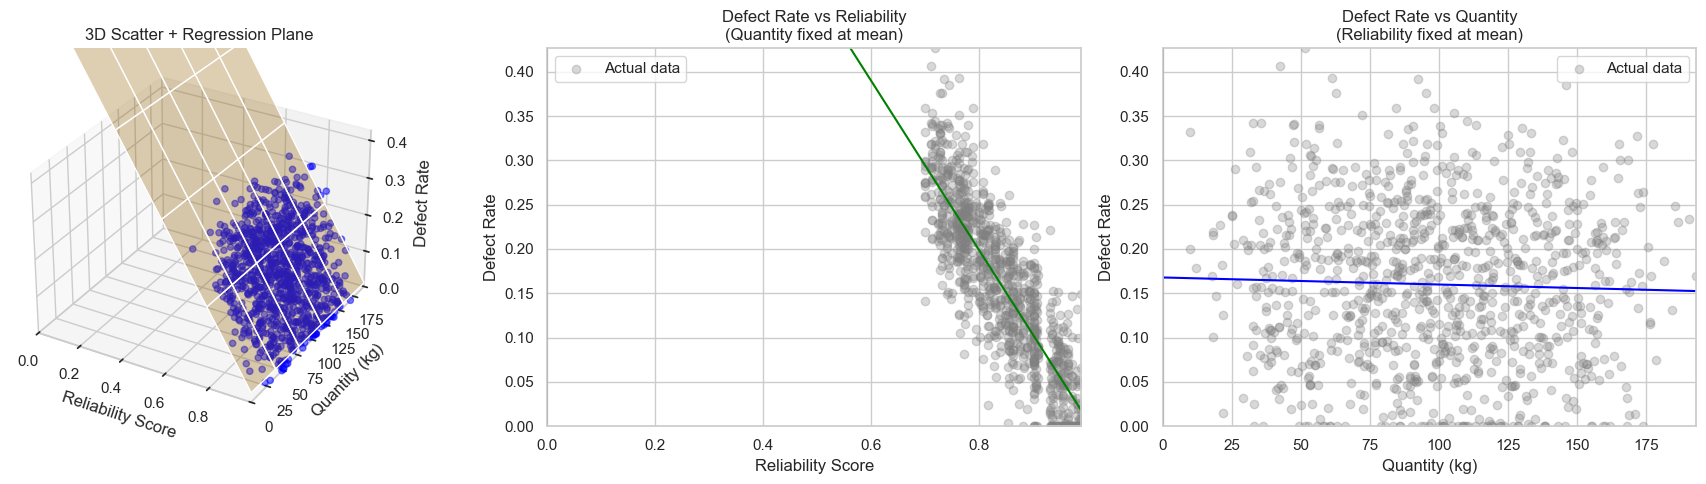

In [64]:
# Here we are doing a linear regression.
# Here we are performing a linear regression.
# This predictive model estimates how the defect rate changes with each unit increase in reliability and quantity.

# The coefficients (slopes) are approximately:
#   - Reliability: -9.56 (strong negative effect, meaning higher reliability leads to lower defects)
#   - Quantity: -0.00007947 (very small effect, almost negligible impact on defects)

# We visualize this with a 3D plot showing the combined effect of reliability and quantity on defects,
# along with two 2D plots showing the effect of each variable individually while holding the other constant.

# Conclusion:
# The dependent variable (defect rate) shows a strong negative correlation with reliability (which makes intuitive sense).
# There is a very slight negative correlation between quantity and defect rate.
# Note: These relationships are modeled assuming other variables are held constant.
# The 3D models shows how they all behave together
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

X = merged_all[['reliability_score', 'quantity_kg']] #The reliability_score comes from the supplier, quantity from shipment file
y = merged_all['defect_rate']                        #The defect_rate is from the inspections file

model = LinearRegression()    #This create a regresssion model using a straight line
model.fit(X, y)               #The gives the line of best fit with the three variables, X storing ['reliability_score', 'quantity_kg'], and y is defect_rate

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Assuming your fitted model and data are already set up:
# model = LinearRegression().fit(X, y)

# ----- 3D Plot -----
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')

# 3D scatter
ax1.scatter(X['reliability_score'], X['quantity_kg'], y, c='blue', marker='o', alpha=0.5)

# Grid for the regression plane
reliability_range = np.linspace(0, X['reliability_score'].max(), 6)
quantity_range = np.linspace(0, X['quantity_kg'].max(), 6)
R_grid, Q_grid = np.meshgrid(reliability_range, quantity_range)
X_grid_3d = np.c_[R_grid.ravel(), Q_grid.ravel()]

# Predict defect rates on the grid
predicted_defect_grid = model.predict(
    pd.DataFrame(X_grid_3d, columns=['reliability_score', 'quantity_kg'])
).reshape(R_grid.shape)

# Plot regression plane
ax1.plot_surface(R_grid, Q_grid, predicted_defect_grid, color='orange', alpha=0.3)

# Labels and limits starting from 0
ax1.set_xlabel('Reliability Score')
ax1.set_ylabel('Quantity (kg)')
ax1.set_zlabel('Defect Rate')
ax1.set_xlim(0, X['reliability_score'].max())
ax1.set_ylim(0, X['quantity_kg'].max())
ax1.set_zlim(0, y.max())
ax1.set_title('3D Scatter + Regression Plane')

# ----- 2D: Defect vs Reliability (Quantity fixed) -----
ax2 = fig.add_subplot(1, 3, 2)

fixed_quantity = X['quantity_kg'].mean()
reliability_range = np.linspace(0, X['reliability_score'].max(), 100)
predicted_defect_reliability = model.predict(
    pd.DataFrame(np.column_stack((reliability_range, np.full_like(reliability_range, fixed_quantity))),
                 columns=['reliability_score', 'quantity_kg'])
)

ax2.plot(reliability_range, predicted_defect_reliability, color='green')
ax2.scatter(X['reliability_score'], y, alpha=0.3, color='gray', label='Actual data')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)
ax2.set_xlim(0, X['reliability_score'].max())
ax2.set_ylim(0, y.max())
ax2.set_xlabel('Reliability Score')
ax2.set_ylabel('Defect Rate')
ax2.set_title('Defect Rate vs Reliability\n(Quantity fixed at mean)')
ax2.grid(True)
ax2.legend()

# ----- 2D: Defect vs Quantity (Reliability fixed) -----
ax3 = fig.add_subplot(1, 3, 3)

fixed_reliability = X['reliability_score'].mean()
quantity_range = np.linspace(0, X['quantity_kg'].max(), 100)
predicted_defect_quantity = model.predict(
    pd.DataFrame(np.column_stack((np.full_like(quantity_range, fixed_reliability), quantity_range)),
                 columns=['reliability_score', 'quantity_kg'])
)

ax3.plot(quantity_range, predicted_defect_quantity, color='blue')
ax3.scatter(X['quantity_kg'], y, alpha=0.3, color='gray', label='Actual data')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.axvline(0, color='black', linewidth=0.5)
ax3.set_xlim(0, X['quantity_kg'].max())
ax3.set_ylim(0, y.max())
ax3.set_xlabel('Quantity (kg)')
ax3.set_ylabel('Defect Rate')
ax3.set_title('Defect Rate vs Quantity\n(Reliability fixed at mean)')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()


In [65]:
#The R² value to predict how reliable the data is form 0 to 1. The hight the value the more you can 
#assume that the independant variable effect the dependant one. In this case how well does the reliablilty
#score and quantity effect the defect rate.
from sklearn.metrics import r2_score

# Get predictions on your existing data
y_pred = model.predict(X)

# Compute R²
r2 = r2_score(y, y_pred)
print(f"R² score: {r2:.4f}")
#when you run the code you will get a score of 0.7224, that means that 72.24% of 
#of the variability in defect rate are explained by the reliabilty_score in the inspection file and quantity

#We get the value by summing the total of the residual squares, and put that over the sum of the total sqaures
#which is got by subtrating the averages of y from the residual and squaring the values, then subtract this fraction by 1

R² score: 0.7224


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


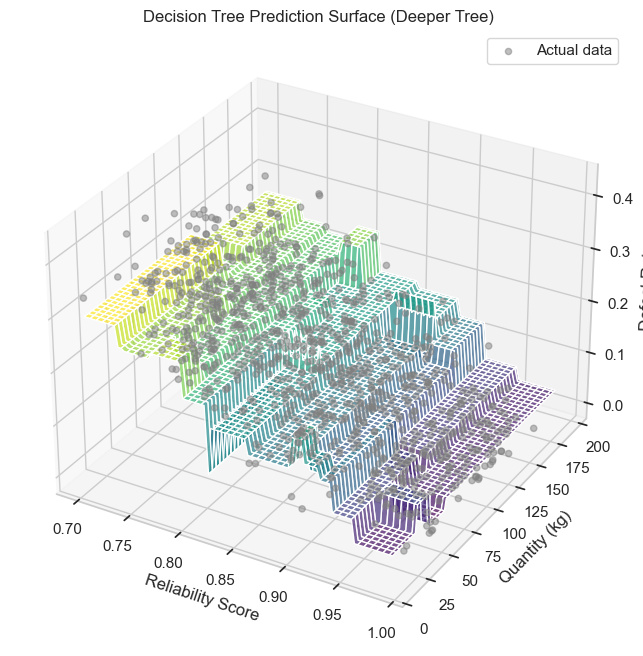

Predicted defect rate: 0.1274


In [86]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fit deeper tree (you can change depth)
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_model.fit(X, y)

# Make grid of inputs
reliability_range = np.linspace(X['reliability_score'].min(), X['reliability_score'].max(), 100)
quantity_range = np.linspace(X['quantity_kg'].min(), X['quantity_kg'].max(), 100)
R_grid, Q_grid = np.meshgrid(reliability_range, quantity_range)
grid_inputs = np.c_[R_grid.ravel(), Q_grid.ravel()]

# Predict on grid
Z_pred = tree_model.predict(grid_inputs).reshape(R_grid.shape)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Actual data
ax.scatter(X['reliability_score'], X['quantity_kg'], y, c='gray', alpha=0.5, label='Actual data')

# Prediction surface
surface = ax.plot_surface(R_grid, Q_grid, Z_pred, cmap='viridis', alpha=0.7)

ax.set_xlabel('Reliability Score')
ax.set_ylabel('Quantity (kg)')
ax.set_zlabel('Defect Rate')
ax.set_title('Decision Tree Prediction Surface (Deeper Tree)')
plt.legend()
plt.show()

sample = pd.DataFrame({'reliability_score': [0.9], 'quantity_kg': [600]})
prediction = tree_model.predict(sample)
print(f"Predicted defect rate: {prediction[0]:.4f}")



Decision Tree R² score on test data: 0.6717


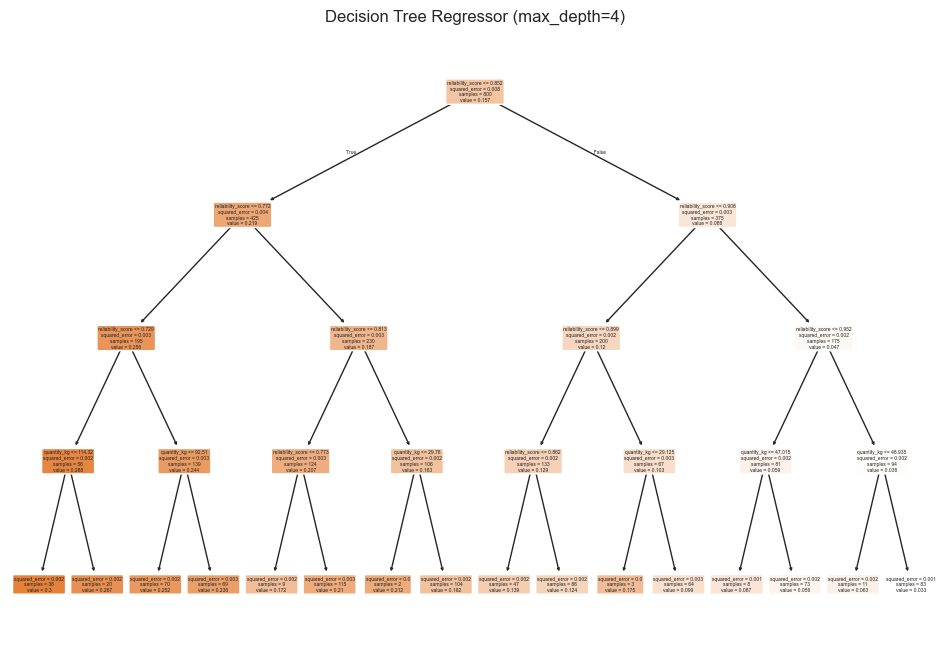

Predicted defect rate for sample: 0.0991


In [95]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Features and target
X = merged_all[['reliability_score', 'quantity_kg']]
y = merged_all['defect_rate']

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit model
tree_model = DecisionTreeRegressor(random_state=42, max_depth=4) #given that we are dealing with 1000 columns 4 deep here is enough
tree_model.fit(X_train, y_train)

# Predict on test set
y_pred_test = tree_model.predict(X_test)

# Calculate R² on test data
r2_test = r2_score(y_test, y_pred_test)
print(f"Decision Tree R² score on test data: {r2_test:.4f}")

# Visualize tree
plt.figure(figsize=(12,8))
plot_tree(tree_model, feature_names=['reliability_score', 'quantity_kg'], filled=True, rounded=True)
plt.title("Decision Tree Regressor (max_depth=4)")
plt.show()

# Sample prediction
sample = pd.DataFrame({'reliability_score': [0.9], 'quantity_kg': [600]})
pred = tree_model.predict(sample)
print(f"Predicted defect rate for sample: {pred[0]:.4f}")
